In [1]:
%pip install xgboost

%pip install gensim

%pip install pyLDAvis

%pip install wordcloud

%pip install lime

import nltk
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 2.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 5.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 27.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3
ERROR: pip's dependency

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import pyLDAvis
import gensim
import xgboost
import wordcloud
import lime
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

Matplotlib is building the font cache; this may take a moment.


nltk==3.8.1
sklearn==1.2.2
pandas==2.0.1
numpy==1.25.0
seaborn==0.12.2
pyLDAvis==3.4.0
gensim==4.3.1
xgboost==1.7.6
wordcloud==1.9.2


In [3]:
seed = 23984

In [102]:
# general preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# text-specific preprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# analysis
from nltk.probability import FreqDist
# topic modeling
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud

# vectorizers and pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

# preprocessing: scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint

# cross-validation
from sklearn.model_selection import cross_validate # can return training score
from sklearn.model_selection import cross_val_score

# evaluating final model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# explain model predictions with LIME
from lime.lime_text import LimeTextExplainer

# estimate feature importance to the model as a whole using permutation importance
from sklearn.inspection import permutation_importance

---

Load data:

In [5]:
read_bucket = "twitter-sxsw"
file_name = "judge-1377884607_tweet_product_company.csv"

In [6]:
data_uri = f"s3://{read_bucket}/{file_name}"
data = pd.read_csv(data_uri, encoding='latin-1')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Clean data:

In [7]:
# rename lengthy column names
data.rename({'emotion_in_tweet_is_directed_at': 'object_of_sentiment',
             'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, axis=1, inplace=True)

In [8]:
# replace "I can't tell" in sentiment column with null
data.sentiment = data.sentiment.replace({"I can't tell": None})
# drop records with null value for sentiment
data.dropna(subset='sentiment', inplace=True)

In [9]:
# drop tweet that is missing tweet_text
data.dropna(subset='tweet_text', inplace=True)

In [10]:
data.head()

,tweet_text,object_of_sentiment,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


---

**ADD EXPLORATORY DATA ANALYSIS**

**END ADDED EXPLORATORY DATA ANALYSIS**

---

Train test split:

In [11]:
seed = 23984

X_train, X_test, y_train, y_test = train_test_split(data['tweet_text'].copy(),
                                                    data['sentiment'].copy(),
                                                    test_size=0.2,
                                                    random_state=seed)

Label encode target:

In [12]:
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(y_train_encoded.shape)
print(y_test_encoded.shape)
print(pd.Series(y_train_encoded).value_counts(normalize=True))
print(pd.Series(y_test_encoded).value_counts(normalize=True))

dict(zip(range(len(le.classes_)), le.classes_))

(7148,)
(1788,)
1    0.602966
2    0.335478
0    0.061556
Name: proportion, dtype: float64
1    0.602908
2    0.324385
0    0.072707
Name: proportion, dtype: float64


{0: 'Negative emotion',
 1: 'No emotion toward brand or product',
 2: 'Positive emotion'}

Preprocess features:

In [13]:
# clean up (remove punctuation & change to lower case) tweets & remove english stopwords
twitter_stopwords = ['sxsw', 'mention', 'link', 'rt']

stopwords_list = stopwords.words('english') + twitter_stopwords

def clean_up(tweet):
    return ' '.join([word.strip(string.punctuation).lower() for word in tweet.split() if
                     word.strip(string.punctuation).lower() not in stopwords_list])

In [15]:
# stemming
from nltk.stem import PorterStemmer

def get_stems(tweet):
    '''Takes in a string of words and outputs a string of stemmed tokens.'''
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in tweet.split()])

In [16]:
# get stemmed tokens for training data & test data
X_train_stems = X_train.apply(clean_up).apply(get_stems)
X_test_stems = X_test.apply(clean_up).apply(get_stems)

X_train_stems.head()

8932    z6 news good news code valid 4:00-7:59:59p 03/...
4997    realli cool shit googl work googl web font loo...
5673    miss google' vp search marissa mayer last week...
8147    yet ipad pop-up store flawless appl ipad 2 lau...
6519    calvin geek charli sheen goddess schmittast googl
Name: tweet_text, dtype: object

Try several different parameter settings for count vectorization:

In [17]:
count_options = [
    CountVectorizer(),
    CountVectorizer(ngram_range=(1,2)),
    CountVectorizer(ngram_range=(1,3)),
    CountVectorizer(min_df=0.01, max_df=0.99),
    CountVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.99),
    CountVectorizer(ngram_range=(1, 3), min_df=0.01, max_df=0.99),
    CountVectorizer(max_features=200, max_df=0.99),
    CountVectorizer(ngram_range=(1, 2), max_features=200, max_df=0.99),
    CountVectorizer(ngram_range=(1,3), max_features=200, max_df=0.99),
    CountVectorizer(max_features=800, max_df=0.99),
    CountVectorizer(ngram_range=(1, 2), max_features=800, max_df=0.99),
    CountVectorizer(ngram_range=(1,3), max_features=800, max_df=0.99),
    CountVectorizer(max_features=3000, max_df=0.99),
    CountVectorizer(ngram_range=(1, 2), max_features=3000, max_df=0.99),
    CountVectorizer(ngram_range=(1,3), max_features=3000, max_df=0.99)
]

Test settings for count vectorization:

In [18]:
%%time

rf = RandomForestClassifier(random_state=seed)
nb = MultinomialNB()
svc = SVC(random_state=seed)

rf_scores = []
nb_scores = []
svc_scores = []

for count in count_options:
    # vectorize
    final_X_train = count.fit_transform(X_train_stems)
    
    # get cross validation scores:
    rf_score = np.mean(cross_val_score(rf, final_X_train, y_train_encoded, scoring='accuracy', cv=3))
    nb_score = np.mean(cross_val_score(nb, final_X_train, y_train_encoded, scoring='accuracy', cv=3))
    svc_score = np.mean(cross_val_score(svc, final_X_train, y_train_encoded, scoring='accuracy', cv=3))
    
    # store results for review:
    rf_scores.append(rf_score)
    nb_scores.append(nb_score)
    svc_scores.append(svc_score)

CPU times: user 11min 47s, sys: 777 ms, total: 11min 48s
Wall time: 12min 9s


In [19]:
best_vectorizer_rf = np.argmax(rf_scores)
best_vectorizer_nb = np.argmax(nb_scores)
best_vectorizer_svc = np.argmax(svc_scores)

count_rf = count_options[best_vectorizer_rf]
count_nb = count_options[best_vectorizer_nb]
count_svc = count_options[best_vectorizer_svc]

print(f'rf: {count_rf}')
print(f'nb: {count_nb}')
print(f'svc: {count_svc}')

rf: CountVectorizer(max_df=0.99, max_features=3000, ngram_range=(1, 3))
nb: CountVectorizer()
svc: CountVectorizer()


In [20]:
# print best scores
print(f'Random forest: {np.max(rf_scores)}')
print(f'Naive bayes: {np.max(nb_scores)}')
print(f'Support vector machine: {np.max(svc_scores)}')

Random forest: 0.6772512499032528
Naive bayes: 0.6544456318363857
Support vector machine: 0.6811682926654529


Does tfidf (term frequency inverse document frequency) vectorization improve the scores?

Again, try several different options for the vectorizer.

In [21]:
tfidf_options = [
    TfidfVectorizer(),
    TfidfVectorizer(ngram_range=(1,2)),
    TfidfVectorizer(ngram_range=(1,3)),
    TfidfVectorizer(min_df=0.01, max_df=0.99),
    TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.99),
    TfidfVectorizer(ngram_range=(1, 3), min_df=0.01, max_df=0.99),
    TfidfVectorizer(max_features=200, max_df=0.99),
    TfidfVectorizer(ngram_range=(1, 2), max_features=200, max_df=0.99),
    TfidfVectorizer(ngram_range=(1,3), max_features=200, max_df=0.99),
    TfidfVectorizer(max_features=800, max_df=0.99),
    TfidfVectorizer(ngram_range=(1, 2), max_features=800, max_df=0.99),
    TfidfVectorizer(ngram_range=(1,3), max_features=800, max_df=0.99),
    TfidfVectorizer(max_features=3000, max_df=0.99),
    TfidfVectorizer(ngram_range=(1, 2), max_features=3000, max_df=0.99),
    TfidfVectorizer(ngram_range=(1,3), max_features=3000, max_df=0.99)
]

Search for best settings:

In [22]:
%%time

rf = RandomForestClassifier(random_state=seed)
nb = MultinomialNB()
svc = SVC(random_state=seed)

rf_tfidf_scores = []
nb_tfidf_scores = []
svc_tfidf_scores = []

for tfidf in tfidf_options:
    # vectorize
    final_X_train = tfidf.fit_transform(X_train_stems)
    
    # get cross validation scores:
    rf_score = np.mean(cross_val_score(rf, final_X_train, y_train_encoded, scoring='accuracy', cv=3))
    nb_score = np.mean(cross_val_score(nb, final_X_train, y_train_encoded, scoring='accuracy', cv=3))
    svc_score = np.mean(cross_val_score(svc, final_X_train, y_train_encoded, scoring='accuracy', cv=3))
    
    # store results for review:
    rf_tfidf_scores.append(rf_score)
    nb_tfidf_scores.append(nb_score)
    svc_tfidf_scores.append(svc_score)

CPU times: user 11min 29s, sys: 880 ms, total: 11min 30s
Wall time: 11min 41s


Print best scores with tfidf vectorization:

In [23]:
# print best scores
print(f'Random forest: {np.max(rf_tfidf_scores)}')
print(f'Naive bayes: {np.max(nb_tfidf_scores)}')
print(f'Support vector machine: {np.max(svc_tfidf_scores)}')

Random forest: 0.6752931102257936
Naive bayes: 0.6696962778257549
Support vector machine: 0.6811678815999936


Tfidf vectorization improved the best score for naive bayes, and gave similar results with random forest and support vector machine. We will use tfidf vectorization moving forward.

In [28]:
tfidf_rf = tfidf_options[np.argmax(rf_tfidf_scores)]
tfidf_nb = tfidf_options[np.argmax(nb_tfidf_scores)]
tfidf_svc = tfidf_options[np.argmax(svc_tfidf_scores)]

print(f'rf: {tfidf_rf}')
print(f'nb: {tfidf_nb}')
print(f'svc: {tfidf_svc}')

rf: TfidfVectorizer(max_df=0.99, max_features=3000)
nb: TfidfVectorizer(max_df=0.99, max_features=3000, ngram_range=(1, 2))
svc: TfidfVectorizer(max_df=0.99, max_features=3000)


In [ ]:
TfidfVectorizer()

The best vectorizers include only words that occur in less than 99% of all tweets, and the vocabulary is limited to the top 3000 terms, in decreasing order of term frequency. The vectorizer utilized by the naive bayes algorithm also includes bigrams.

Examine baseline models:

In [29]:
rf_pipe = Pipeline(steps=[
    ('vec', tfidf_rf),
    ('clf', rf)
])

baseline_rf_cv = cross_validate(rf_pipe, X_train_stems, y_train_encoded, scoring='accuracy', return_train_score=True)

In [37]:
print(f'Baseline random forest results')
print(f"Mean validation accuracy: {np.mean(baseline_rf_cv['test_score'])}")
print(f"Mean training accuracy: {np.mean(baseline_rf_cv['train_score'])}")

Baseline random forest results
Mean validation accuracy: 0.6759915242210554
Mean training accuracy: 0.9632064066557472


Our baseline random forest is extremely overfit, with a mean validation accuracy of ~67.6%.

In [33]:
nb_pipe = Pipeline(steps=[
    ('vec', tfidf_nb),
    ('clf', nb)
])

baseline_nb_cv = cross_validate(nb_pipe, X_train_stems, y_train_encoded, scoring='accuracy', return_train_score=True)

In [34]:
print(f'Baseline naive bayes results')
print(f"Mean validation accuracy: {np.mean(baseline_nb_cv['test_score'])}")
print(f"Mean training accuracy: {np.mean(baseline_nb_cv['train_score'])}")

Baseline naive bayes results
Mean validation accuracy: 0.6675959030472677
Mean training accuracy: 0.7559456059803479


Naive bayes is also overfit, and the best validation accuracy we have is slightly lower than that of the baseline random forest, 66.7% accuracy versus 67.6% accuracy.

In [35]:
svc_pipe = Pipeline(steps=[
    ('vec', tfidf_svc),
    ('clf', svc)
])

baseline_svc_cv = cross_validate(svc_pipe, X_train_stems, y_train_encoded, scoring='accuracy', return_train_score=True)

In [36]:
print(f'Baseline support vector classifier results')
print(f"Mean validation accuracy: {np.mean(baseline_svc_cv['test_score'])}")
print(f"Mean training accuracy: {np.mean(baseline_svc_cv['train_score'])}")

Baseline support vector classifier results
Mean validation accuracy: 0.6874624046352528
Mean training accuracy: 0.8894795127353268


Interestly, the baseline support vector machine has the best mean validation accuracy of ~68.7%, outperforming even the baseline random forest. SVC is also slightly less overfit than rf (though still quite overfit.)

----

Hyperparameter tuning:

**Random Forest**

[Skip to the results of hyperparameter tuning](#test-id)

Baseline:

In [38]:
np.mean(baseline_rf_cv['test_score'])

0.6759915242210554

In [39]:
np.mean(baseline_rf_cv['train_score'])

0.9632064066557472

A random forest with default settings is extremely overfit.

Hyperparameter tuning approach (to reduce overfitting):

Preventing Individual Trees from Overfitting to the Data:
- Increase min_samples_leaf
- Decrease max_depth

Preventing the Forest as a Whole from Overfitting to the Data:
- Increase n_estimators
- Decrease max_samples (each tree trains on fewer samples from the full training dataset)
- Decrease max_features (at each split, only consider max_features)

In [40]:
%%time

rf_params = {'clf__min_samples_leaf': randint(1, 50),
             'clf__max_depth': randint(1, 500),
             'clf__n_estimators': randint(5, 300),
             'clf__max_samples': uniform(0.05, 1),
             'clf__max_features': [1, 200, 500, 3000], # 3000 is the num of features in rf count vec
             'clf__random_state': [seed]}

rf_search = RandomizedSearchCV(rf_pipe, rf_params, n_iter=10, scoring='accuracy', cv=3, random_state=seed,
                               return_train_score=True)

rf_search.fit(X_train_stems, y_train_encoded)

CPU times: user 1min 44s, sys: 55.4 ms, total: 1min 44s
Wall time: 1min 45s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vec',
                                              TfidfVectorizer(max_df=0.99,
                                                              max_features=3000)),
                                             ('clf',
                                              RandomForestClassifier(random_state=23984))]),
                   param_distributions={'clf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7efc59183eb0>,
                                        'clf__max_features': [1, 200, 500,
                                                              3000],
                                        'clf__max_samples': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7efc59182b30>,
                                        'clf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7efc59182bc0>,
                                        'clf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7efc59182380>,
                                        'clf__random_state': [23984]},
                   random_state=23984, return_train_score=True,
                   scoring='accuracy')

In [41]:
rf_search.best_score_

0.6645193781542668

In [42]:
pd.DataFrame(rf_search.cv_results_).loc[:, ['mean_fit_time', 'params', 'mean_train_score', 'mean_test_score'] ]

,mean_fit_time,params,mean_train_score,mean_test_score
0,0.948006,"{'clf__max_depth': 40, 'clf__max_features': 50...",0.612269,0.606464
1,0.347601,"{'clf__max_depth': 61, 'clf__max_features': 1,...",0.602966,0.602966
2,11.500201,"{'clf__max_depth': 435, 'clf__max_features': 3...",0.690962,0.623110
3,0.955216,"{'clf__max_depth': 454, 'clf__max_features': 5...",0.641507,0.628707
4,5.323485,"{'clf__max_depth': 471, 'clf__max_features': 5...",0.795607,0.664519
5,2.339562,"{'clf__max_depth': 434, 'clf__max_features': 3...",0.662563,0.619334
6,3.301865,"{'clf__max_depth': 225, 'clf__max_features': 5...",0.678371,0.642556
7,3.851470,"{'clf__max_depth': 268, 'clf__max_features': 3...",0.698307,0.629825
8,0.313046,"{'clf__max_depth': 492, 'clf__max_features': 1...",0.602966,0.602966
9,0.243397,"{'clf__max_depth': 41, 'clf__max_features': 1,...",0.602966,0.602966


The models trained during the randomized search are no longer overfit, though they have poorer performance on the validation set than the baseline random forest.

Let's increase the number of iterations run in case we can find a better fit somewhere in the search space.

In [43]:
rf_params = {'clf__min_samples_leaf': randint(1, 50),
             'clf__max_depth': randint(1, 500),
             'clf__n_estimators': randint(5, 300),
             'clf__max_samples': uniform(0.05, 1),
             'clf__max_features': [1, 200, 500, 3000], # 3000 is the num of features in rf count vec
             'clf__random_state': [seed]}

rf_search2 = RandomizedSearchCV(rf_pipe, rf_params, n_iter=30, scoring='accuracy', cv=3, random_state=seed,
                               return_train_score=True)

rf_search2.fit(X_train_stems, y_train_encoded)

rf_search2.best_score_

0.6645193781542668

In [44]:
rf_search2.best_estimator_

Pipeline(steps=[('vec', TfidfVectorizer(max_df=0.99, max_features=3000)),
                ('clf',
                 RandomForestClassifier(max_depth=471, max_features=500,
                                        max_samples=0.5280412752266249,
                                        min_samples_leaf=3, n_estimators=174,
                                        random_state=23984))])

In [45]:
rf_search.cv_results_['mean_train_score'][rf_search.best_index_]

0.7956069553531288

Once again, the best performing model is overfit.

In [46]:
pd.DataFrame(rf_search2.cv_results_).loc[:, ['mean_fit_time', 'params', 'mean_train_score', 'mean_test_score'] ]

,mean_fit_time,params,mean_train_score,mean_test_score
0,0.943992,"{'clf__max_depth': 40, 'clf__max_features': 50...",0.612269,0.606464
1,0.356500,"{'clf__max_depth': 61, 'clf__max_features': 1,...",0.602966,0.602966
2,11.246279,"{'clf__max_depth': 435, 'clf__max_features': 3...",0.690962,0.623110
3,0.959082,"{'clf__max_depth': 454, 'clf__max_features': 5...",0.641507,0.628707
4,5.283556,"{'clf__max_depth': 471, 'clf__max_features': 5...",0.795607,0.664519
5,2.349927,"{'clf__max_depth': 434, 'clf__max_features': 3...",0.662563,0.619334
6,3.502991,"{'clf__max_depth': 225, 'clf__max_features': 5...",0.678371,0.642556
7,3.746972,"{'clf__max_depth': 268, 'clf__max_features': 3...",0.698307,0.629825
8,0.320158,"{'clf__max_depth': 492, 'clf__max_features': 1...",0.602966,0.602966
9,0.245917,"{'clf__max_depth': 41, 'clf__max_features': 1,...",0.602966,0.602966


It is difficult to detect patterns in the randomized search cv results format. Ideally, I want to reduce variance in the model until it is underfit, then re-introduce variance slowly to find the optimal point between underfitting and overfitting.

In [47]:
no_samples = [1, 3, 5, 10, 20, 30, 50]

train_scores = []
val_scores = []

for num in no_samples:
    # instantiate a random forest with that value for min samples leaf
    tuning_rf = RandomForestClassifier(random_state=seed, min_samples_leaf=num)
    # instantiate a pipeline
    rf_tuning_pipe = Pipeline(steps=[
        ('vec', tfidf_rf),
        ('clf', tuning_rf)
    ])
    # perform cross validation
    cv_results = cross_validate(rf_tuning_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3,
                                return_train_score=True)
    # record mean performance
    train_scores.append(np.mean(cv_results['train_score']))
    val_scores.append(np.mean(cv_results['test_score']))

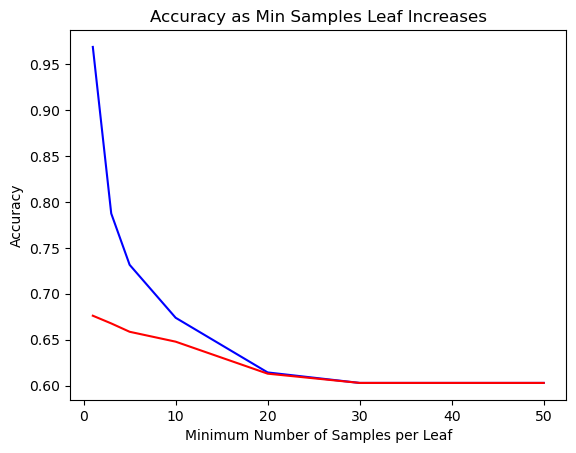

In [48]:
fig, ax = plt.subplots()

ax.set_title('Accuracy as Min Samples Leaf Increases')
plt.plot(no_samples, train_scores, label='train', c='b')
plt.plot(no_samples, val_scores, label='val', c='r')
ax.set_xlabel('Minimum Number of Samples per Leaf')
ax.set_ylabel('Accuracy');

Demanding that more samples are preserved per leaf results in a decrease in both training and validation accuracy. The model is no longer overfit to the training data when min_samples_leaf reaches a value of ~20.

In [49]:
no_max_samples = np.linspace(0.05, 1, 9)

train_scores = []
val_scores = []

for num in no_max_samples:
    # instantiate a random forest with that value for min samples leaf
    tuning_rf = RandomForestClassifier(random_state=seed, max_samples=num)
    # instantiate a pipeline
    rf_tuning_pipe = Pipeline(steps=[
        ('vec', tfidf_rf),
        ('clf', tuning_rf)
    ])
    # perform cross validation
    cv_results = cross_validate(rf_tuning_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3,
                                return_train_score=True)
    # record mean performance
    train_scores.append(np.mean(cv_results['train_score']))
    val_scores.append(np.mean(cv_results['test_score']))

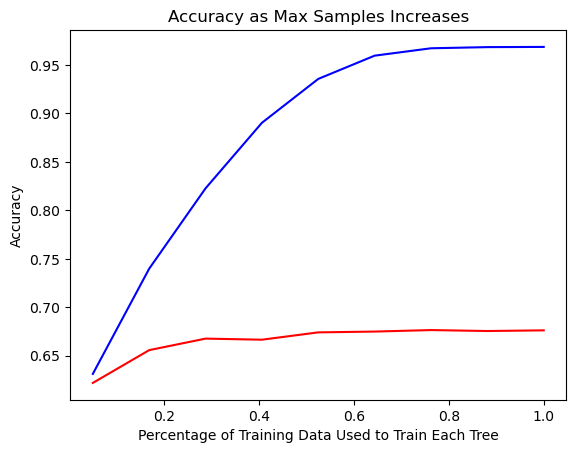

In [50]:
fig, ax = plt.subplots()

ax.set_title('Accuracy as Max Samples Increases')
plt.plot(no_max_samples, train_scores, label='train', c='b')
plt.plot(no_max_samples, val_scores, label='val', c='r')
ax.set_xlabel('Percentage of Training Data Used to Train Each Tree')
ax.set_ylabel('Accuracy');

In [51]:
print(f'Percentage of dataset used to train each tree: {no_max_samples[np.argmax(val_scores)]}')
print(f'Validation accuracy: {np.max(val_scores)}')

Percentage of dataset used to train each tree: 0.7625
Validation accuracy: 0.6764122065770709


A random forest with max_samples set to 0.7625 results in a validation accuracy *slightly* higher than that of the baseline. We can see that this value of max_samples is roughly where validation accuracy "levels out" and stops improving as well.

In [55]:
no_feats = np.linspace(0.01, 0.99, 10)

train_scores = []
val_scores = []

for num in no_feats:
    # instantiate a random forest with that value for min samples leaf
    tuning_rf = RandomForestClassifier(random_state=seed, max_samples=0.7625, max_features=num)
    # instantiate a pipeline
    rf_tuning_pipe = Pipeline(steps=[
        ('vec', tfidf_rf),
        ('clf', tuning_rf)
    ])
    # perform cross validation
    cv_results = cross_validate(rf_tuning_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3,
                                return_train_score=True)
    # record mean performance
    train_scores.append(np.mean(cv_results['train_score']))
    val_scores.append(np.mean(cv_results['test_score']))

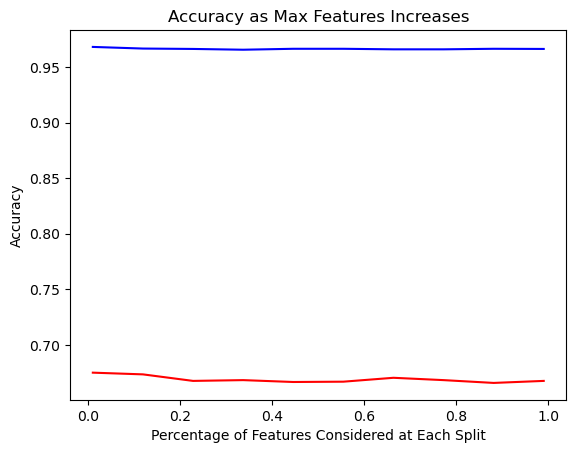

In [56]:
fig, ax = plt.subplots()

ax.set_title('Accuracy as Max Features Increases')
plt.plot(no_feats, train_scores, label='train', c='b')
plt.plot(no_feats, val_scores, label='val', c='r')
ax.set_xlabel('Percentage of Features Considered at Each Split')
ax.set_ylabel('Accuracy');

Varying the number of features considered at each split had little effect on the validation accuracy.

As a last experiment, increase the number of estimators.

In [58]:
no_estimators = [100, 200, 300, 400, 500]

train_scores = []
val_scores = []

for num in no_estimators:
    # instantiate a random forest with that value for min samples leaf
    tuning_rf = RandomForestClassifier(random_state=seed, max_samples=0.7625, n_estimators=num)
    # instantiate a pipeline
    rf_tuning_pipe = Pipeline(steps=[
        ('vec', count_rf),
        ('clf', tuning_rf)
    ])
    # perform cross validation
    cv_results = cross_validate(rf_tuning_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3,
                                return_train_score=True)
    # record mean performance
    train_scores.append(np.mean(cv_results['train_score']))
    val_scores.append(np.mean(cv_results['test_score']))

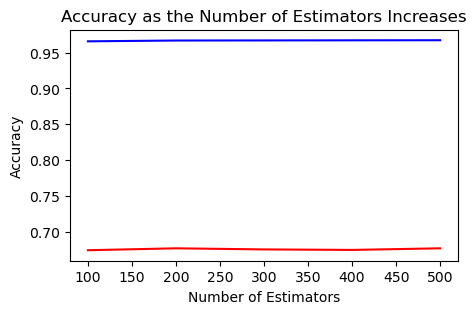

In [59]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.set_title('Accuracy as the Number of Estimators Increases')
plt.plot(no_estimators, train_scores, label='train', c='b')
plt.plot(no_estimators, val_scores, label='val', c='r')
ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Accuracy');

In [62]:
print(no_estimators[np.argmax(val_scores)])
print(f'score: {np.max(val_scores)}')

500
score: 0.6766917310894328


It's possible that I missed a more optimal number of estimators less than 100.

In [64]:
no_estimators = [10, 20, 50, 80, 100]

train_scores = []
val_scores = []

for num in no_estimators:
    # instantiate a random forest with that value for min samples leaf
    tuning_rf = RandomForestClassifier(random_state=seed, max_samples=0.7625, n_estimators=num)
    # instantiate a pipeline
    rf_tuning_pipe = Pipeline(steps=[
        ('vec', count_rf),
        ('clf', tuning_rf)
    ])
    # perform cross validation
    cv_results = cross_validate(rf_tuning_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3,
                                return_train_score=True)
    # record mean performance
    train_scores.append(np.mean(cv_results['train_score']))
    val_scores.append(np.mean(cv_results['test_score']))

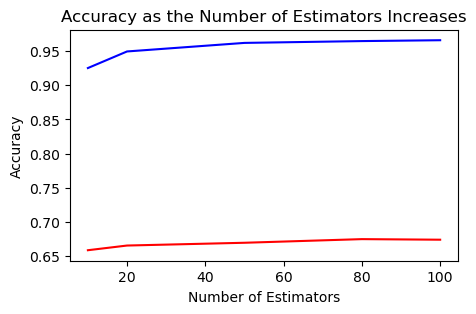

In [65]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.set_title('Accuracy as the Number of Estimators Increases')
plt.plot(no_estimators, train_scores, label='train', c='b')
plt.plot(no_estimators, val_scores, label='val', c='r')
ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Accuracy');

In [66]:
print(np.max(val_scores))

0.6748731187736062


The default number of estimators performs very similar to 500 estimators, and results in a much simpler model.

<a id="test-id"></a>
Results of hyperparameter tuning for random forest:

The best random forest so far has a max_samples value of 0.7625, and otherwise, default hyperparameter settings.

Best Random Forest Classifier so Far:

In [68]:
best_rf = RandomForestClassifier(random_state=seed, max_samples=0.7625)

best_rf_pipe = Pipeline(steps=[
    ('vec', tfidf_rf),
    ('clf', best_rf)
])

np.mean(cross_val_score(best_rf_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3))

0.6764122065770709

---

Hyperparameter tuning:

**Support Vector Machine**

Baseline:

In [69]:
np.mean(baseline_svc_cv['test_score'])

0.6874624046352528

In [70]:
np.mean(baseline_svc_cv['train_score'])

0.8894795127353268

A support vector machine with default settings is overfit.

Hyperparameter tuning approach (to reduce overfitting):

Decreasing Overfitting:
- Decrease gamma (more widespread influence of each training example produces a smoother model)
- Decrease C (inverse regularization parameter; smaller values of C result in a larger margin for hyperplane at the cost of possibly mis-classifying some training examples)

Other Parameters:
- It is possible to change the kernel from the default rbf. I don't expect a linear kernel to perform well, but it is worth trying a poly kernel with varying degrees.

In order to decrease gamma, I need to know it's default value. The documentation states that gamma scales automatically to 1 / (n_features\*X.var()) as the default setting for a support vector classifier.

In [72]:
# figure out default value of gamma

svc_train = tfidf_svc.fit_transform(X_train_stems).todense() # use all training data; close enough

1 / (svc_train.shape[1] * np.var(svc_train))

1.0028897193181587

In [73]:
%%time

svc_params = {'clf__gamma': uniform(10**(-9), 1),
              'clf__C': uniform(0.001, 1)}

svc_search = RandomizedSearchCV(svc_pipe, svc_params, n_iter=10, scoring='accuracy', cv=3, random_state=seed,
                               return_train_score=True)

svc_search.fit(X_train_stems, y_train_encoded)

CPU times: user 3min, sys: 704 ms, total: 3min
Wall time: 3min 4s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vec',
                                              TfidfVectorizer(max_df=0.99,
                                                              max_features=3000)),
                                             ('clf', SVC(random_state=23984))]),
                   param_distributions={'clf__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7efc547f6830>,
                                        'clf__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7efc54823370>},
                   random_state=23984, return_train_score=True,
                   scoring='accuracy')

In [74]:
svc_search.best_score_

0.6745927721303255

In [75]:
pd.DataFrame(svc_search.cv_results_).loc[:, ['mean_fit_time', 'params', 'mean_train_score', 'mean_test_score'] ]

,mean_fit_time,params,mean_train_score,mean_test_score
0,3.310714,"{'clf__C': 0.9450879921538776, 'clf__gamma': 0...",0.768046,0.674453
1,3.038130,"{'clf__C': 0.8457458533704003, 'clf__gamma': 0...",0.604015,0.603805
2,2.766242,"{'clf__C': 0.999330987290495, 'clf__gamma': 0....",0.780078,0.674453
3,3.100416,"{'clf__C': 0.4279760028148768, 'clf__gamma': 0...",0.689913,0.643536
4,2.823812,"{'clf__C': 0.5261527535228282, 'clf__gamma': 0...",0.713626,0.655287
5,3.169831,"{'clf__C': 0.2856759018469842, 'clf__gamma': 0...",0.635982,0.621572
6,2.641755,"{'clf__C': 0.1392853031950474, 'clf__gamma': 0...",0.602966,0.602966
7,3.015093,"{'clf__C': 0.8521402786967658, 'clf__gamma': 0...",0.787003,0.674593
8,2.720714,"{'clf__C': 0.3299017503943551, 'clf__gamma': 0...",0.635142,0.624370
9,2.613670,"{'clf__C': 0.810173825671187, 'clf__gamma': 0....",0.685086,0.649691


As with the first search for the optimal hyperparameters for the random forest algorithm, the performance of the models tested on the validation data is sub-optimal compared to the baseline, but these models are (generally) not (as) overfit, whereas the baseline model is overfit.

Try increasing the number of iterations of the random search.

In [76]:
%%time

svc_params = {'clf__C': uniform(10**(-9), 1),
              'clf__gamma': uniform(0.001, 0.09)}

svc_search2 = RandomizedSearchCV(svc_pipe, svc_params, n_iter=30, scoring='accuracy', cv=3, random_state=seed,
                               return_train_score=True)

svc_search2.fit(X_train_stems, y_train_encoded)

svc_search2.best_score_

CPU times: user 8min 15s, sys: 1.81 s, total: 8min 16s
Wall time: 8min 25s


0.6137381717382161

The best model obtained so far from random search is still slightly inferior to the baseline model.

Let's experiment with a polynomial kernel for the SVM.

In [77]:
%%time

svc_params = {'clf__kernel': ['poly'],
              'clf__degree': randint(1, 5)}

svc_search3 = RandomizedSearchCV(svc_pipe, svc_params, n_iter=30, scoring='accuracy', cv=3, random_state=seed,
                               return_train_score=True)

svc_search3.fit(X_train_stems, y_train_encoded)

svc_search3.best_score_

CPU times: user 8min 45s, sys: 1.94 s, total: 8min 47s
Wall time: 8min 54s


0.6800477869468865

In [81]:
svc_search3.best_estimator_

Pipeline(steps=[('vec', TfidfVectorizer(max_df=0.99, max_features=3000)),
                ('clf', SVC(degree=1, kernel='poly', random_state=23984))])

This score is getting close to that of the baseline model. I will try adjusting gamma and C with the settings of the best polynomial kernel estimator.

In [78]:
%%time

svc_params = {'clf__C': uniform(10**(-9), 1),
              'clf__gamma': uniform(0.001, 1),
              'clf__kernel': ['poly'],
              'clf__degree': [1]}

svc_search4 = RandomizedSearchCV(svc_pipe, svc_params, n_iter=30, scoring='accuracy', cv=3, random_state=seed,
                               return_train_score=True)

svc_search4.fit(X_train_stems, y_train_encoded)

svc_search4.best_score_

CPU times: user 7min 28s, sys: 445 ms, total: 7min 29s
Wall time: 7min 34s


0.677809652967969

Ultimately, the best support vector machine was the baseline model (with default hyperparameter values.)

----

Hyperparameter tuning:

**XGBoost**

The best performing model so far is a support vector classifier with default settings.

One last option we can try is the popular and high-performing algorithm XG Boost.

In [82]:
%pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [83]:
from xgboost import XGBClassifier

Because XGBoost is based on the concept of a random forest, I will use the tfidf vectorization that worked best with the baseline random forest model.

In [84]:
xgb = XGBClassifier(random_state=seed)

xgb_pipe = Pipeline(steps=[
    ('vec', tfidf_rf),
    ('clf', xgb)
])

cv_results = cross_validate(xgb_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3,
                            return_train_score=True)

In [88]:
print(f"Mean Training Accuracy: {np.mean(cv_results['train_score'])}")

Mean Training Accuracy: 0.8602406547368214


In [89]:
print(f"Mean Validation Accuracy: {np.mean(cv_results['test_score'])}")

Mean Validation Accuracy: 0.6709550189859391


The baseline accuracy score for an XGBoost classifier with default hyperparameters is ~67.1%, worse than our baseline support vector machine.

Refine the search.

In [95]:
%%time

xgb_params = {'clf__n_estimators': randint(20, 120),
              'clf__eta': uniform(0.1, 0.5),
              'clf__gamma': uniform(0, 10),
              'clf__max_depth': randint(4, 10),
              'clf__reg_lambda': uniform(0, 1),
              'clf__max_leaves': randint(250, 750)}

xgb_search = RandomizedSearchCV(xgb_pipe, xgb_params, n_iter=50, scoring='accuracy', cv=3, random_state=seed,
                                return_train_score=True)

xgb_search.fit(X_train_stems, y_train_encoded)

xgb_search.best_score_

CPU times: user 14min 27s, sys: 2.9 s, total: 14min 30s
Wall time: 7min 41s


0.6751519973259605

In [96]:
xgb_search.best_estimator_

Pipeline(steps=[('vec', TfidfVectorizer(max_df=0.99, max_features=3000)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.2740001992937563,
                               eval_metric=None, feature_types=None,
                               gamma=0.45342483650972265, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=586,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=84,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [97]:
xgb_search.best_params_

{'clf__eta': 0.2740001992937563,
 'clf__gamma': 0.45342483650972265,
 'clf__max_depth': 6,
 'clf__max_leaves': 586,
 'clf__n_estimators': 84,
 'clf__reg_lambda': 0.8474721440840819}

In [ ]:
%%time

xgb_params = {'clf__n_estimators': randint(70, 110),
              'clf__eta': uniform(0.3, 0.4),
              'clf__gamma': uniform(1, 2),
              'clf__max_depth': randint(4, 10),
              'clf__reg_lambda': uniform(0, 1),
              'clf__max_leaves': [0, 500, 1000]}

xgb_search = RandomizedSearchCV(xgb_pipe, xgb_params, n_iter=50, scoring='accuracy', cv=3, random_state=seed,
                                return_train_score=True)

xgb_search.fit(X_train_stems, y_train_encoded)

xgb_search.best_score_

In [194]:
xgb_params = {'clf__n_estimators': randint(80, 100),
              'clf__eta': uniform(0.5, 0.7),
              'clf__gamma': uniform(0.75, 0.97),
              'clf__max_depth': randint(2, 6),
              'clf__reg_lambda': uniform(0.01, 0.05)}

xgb_search2 = RandomizedSearchCV(xgb_pipe, xgb_params, n_iter=50, scoring='accuracy', cv=3, random_state=seed,
                                return_train_score=True)

xgb_search2.fit(X_train_stems, y_train_encoded)

xgb_search2.best_score_

0.6836864209458287

In [195]:
xgb_search2.best_params_

{'clf__eta': 0.797611698096264,
 'clf__gamma': 0.8580053225064586,
 'clf__max_depth': 4,
 'clf__n_estimators': 81,
 'clf__reg_lambda': 0.021308051442514978}

A baseline support vector classifier is performing the best.

----

Best performing model so far:

In [122]:
svc_pipe = Pipeline(steps=[
    ('vectorize', tfidf_svc),
    ('classify', SVC(random_state=seed, probability=True))
])

Evaluate on the hold-out test set:

In [123]:
%%time

# fit to all training data
svc_pipe.fit(X_train_stems, y_train_encoded)

# score (accuracy) on hold out test data
svc_pipe.score(X_test_stems, y_test_encoded)

0.6957494407158836

Visualize the results across classes using a confusion matrix:

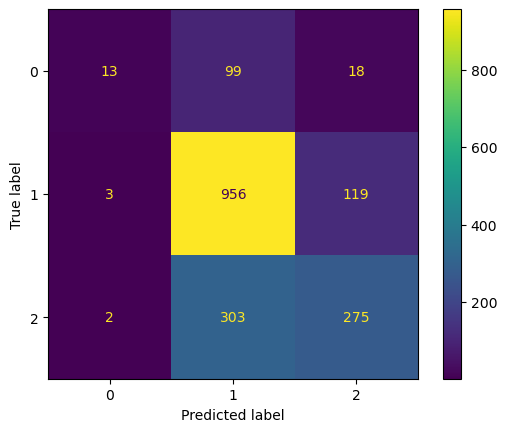

In [124]:
y_test_preds = svc_pipe.predict(X_test_stems)
y_test_true = y_test_encoded.copy()

ConfusionMatrixDisplay(confusion_matrix(y_test_true, y_test_preds)).plot();

In [108]:
dict(zip([0, 1, 2], le.classes_))

{0: 'Negative emotion',
 1: 'No emotion toward brand or product',
 2: 'Positive emotion'}

The model performs the best (unsurprisingly) on neutral tweets, which make up the overwhelming majority of the dataset. The model classifies slightly less than half of positive tweets correctly. The model barely classifies any negative tweets correctly.

Explore the "most negative" and "most positive" tweets. Explain with LIME.

Get the predicted probabilities for the negative class. Then find the 5 tweets for which the model was *most* confident that the tweets were negative.

In [180]:
probability_negative = list(svc_pipe.predict_proba(pd.concat([X_train_stems, X_test_stems], axis=0))[:, 0])

top_5_most_negative_tweets = []

for i in range(5):
    most_negative_iloc = np.argmax(probability_negative)
    true_index = pd.concat([X_train_stems, X_test_stems], axis=0).index[most_negative_iloc]
    
    top_5_most_negative_tweets.append(data.loc[true_index, 'tweet_text'])
    
    probability_negative.pop(most_negative_iloc)

In [181]:
top_5_most_negative_tweets

['Apple...&quot;the classiest fascist company in America&quot; Kara Swisher #sxsw',
 "@mention - got my copy of #Enchantment #ipad #kindle today. So excited. thx for keeping the world enchanted. glad you're at #sxsw again.",
 'First tweet from a plane: Feedback for #Gogo. No registration via FB Connect or Twitter? No PayPal or Google integration to pay you? #SXSW',
 'Just took a survey on iPhone while in Starbucks line. Got a free Starbucks gift card. Instant research. Instant gratification. #sxsw #gsdm',
 "\x89ÛÏ@mention Apple is a great example of a retail store layed out for the future - no 'registers' no 'checkout line'  #sxsw"]

In [166]:
top_5_most_negative_tweets

['apple...&quot;th classiest fascist compani america&quot kara swisher',
 'got copi enchant ipad kindl today excit thx keep world enchant glad',
 'first tweet plane feedback gogo registr via fb connect twitter paypal googl integr pay',
 'took survey iphon starbuck line got free starbuck gift card instant research instant gratif gsdm',
 '\x89ûï@mention appl great exampl retail store lay futur regist checkout line']

Yikes. Perhaps the model did a better job with positive tweets - after all, there were very few negative tweets in the data set.

In [120]:
# use LIME to explain locally
explainer = LimeTextExplainer(class_names=le.classes_)

In [127]:
# most negative
most_negative = X_test_stems.iloc[np.argmax(svc_pipe.predict_proba(X_test_stems)[:, 0])]
most_negative

'apple...&quot;th classiest fascist compani america&quot kara swisher'

In [126]:
# true class
y_test.iloc[np.argmax(svc_pipe.predict_proba(X_test_stems)[:, 0])]

'Negative emotion'

In [129]:
neg_explanation = explainer.explain_instance(most_negative, svc_pipe.predict_proba, num_features=10, labels=[0])

In [132]:
neg_explanation.as_list(label=0)

[('fascist', 0.11150767292709159),
 ('america', 0.08200193507772872),
 ('swisher', 0.06165061891371232),
 ('classiest', 0.05869124456260753),
 ('compani', 0.040117745480130584),
 ('kara', 0.03927208582151227),
 ('quot', 0.017087974734337503),
 ('th', -0.013311370211036915),
 ('apple', 0.0035807326397414656)]

In [133]:
neg_explanation.show_in_notebook()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lime/explanation.py:194: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [134]:
# most positive
most_positive = X_test_stems.iloc[np.argmax(svc_pipe.predict_proba(X_test_stems)[:, 2])]
most_positive

'great ipad app'

In [135]:
# true class
y_test.iloc[np.argmax(svc_pipe.predict_proba(X_test_stems)[:, 2])]

'Positive emotion'

In [136]:
pos_explanation = explainer.explain_instance(most_positive, svc_pipe.predict_proba, num_features=10, labels=[2])

In [137]:
pos_explanation.show_in_notebook()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lime/explanation.py:194: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


To get a sense of the importance of various words/stems to the classifier as a whole, we can use permutation importance from SciKit Learn's inspection package.

Per the [docs](https://scikit-learn.org/stable/modules/permutation_importance.html#:~:text=The%20permutation%20feature%20importance%20is,model%20depends%20on%20the%20feature.):

>The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled [1]. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.

In [154]:
%%time

pi_vectorizer = tfidf_svc
pi_vectorizer.fit(X_train_stems)
X_train_transformed = pd.DataFrame(pi_vectorizer.transform(X_train_stems).todense(), index=X_train_stems.index)
X_test_transformed = pd.DataFrame(pi_vectorizer.transform(X_test_stems).todense(), index=X_test_stems.index)
pi_SVC = SVC(random_state=seed, probability=True)
pi_SVC.fit(X_train_transformed, y_train_encoded)

SVC(probability=True, random_state=23984)

In [ ]:
%%time

results = permutation_importance(pi_SVC,
                                 X_test_transformed,
                                 y_test_encoded,
                                 n_repeats=5,
                                 random_state=seed)

In [ ]:
results

- [x] evaluate on the hold-out test set
- [x] confusion matrix
- [ ] graph feature importance (bar chart) ???
- [x] most positive and most negative tweets
- [x] use SHAP to "explain" the most positive and most negative tweets
- [ ] use SHAP to approx. "feature importance" across all tweets; draw insights from these